In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meme-dataset/val_with_reason.csv
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9273.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9292.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/4353.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/6262.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/2664.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9110.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/1231.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/1017.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/7530.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/85

2025-07-23 17:46:55.398943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753292815.739582      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753292815.833728      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Checking images in train: 100%|██████████| 4050/4050 [00:02<00:00, 1727.68it/s]


train: Removed 388 samples with missing images


Checking images in val: 100%|██████████| 506/506 [00:00<00:00, 1803.63it/s]


val: Removed 0 samples with missing images


Checking images in test: 100%|██████████| 507/507 [00:00<00:00, 1795.59it/s]


test: Removed 0 samples with missing images
Train dataset size: 3662
Validation dataset size: 506
Test dataset size: 507
Displaying Train Samples:


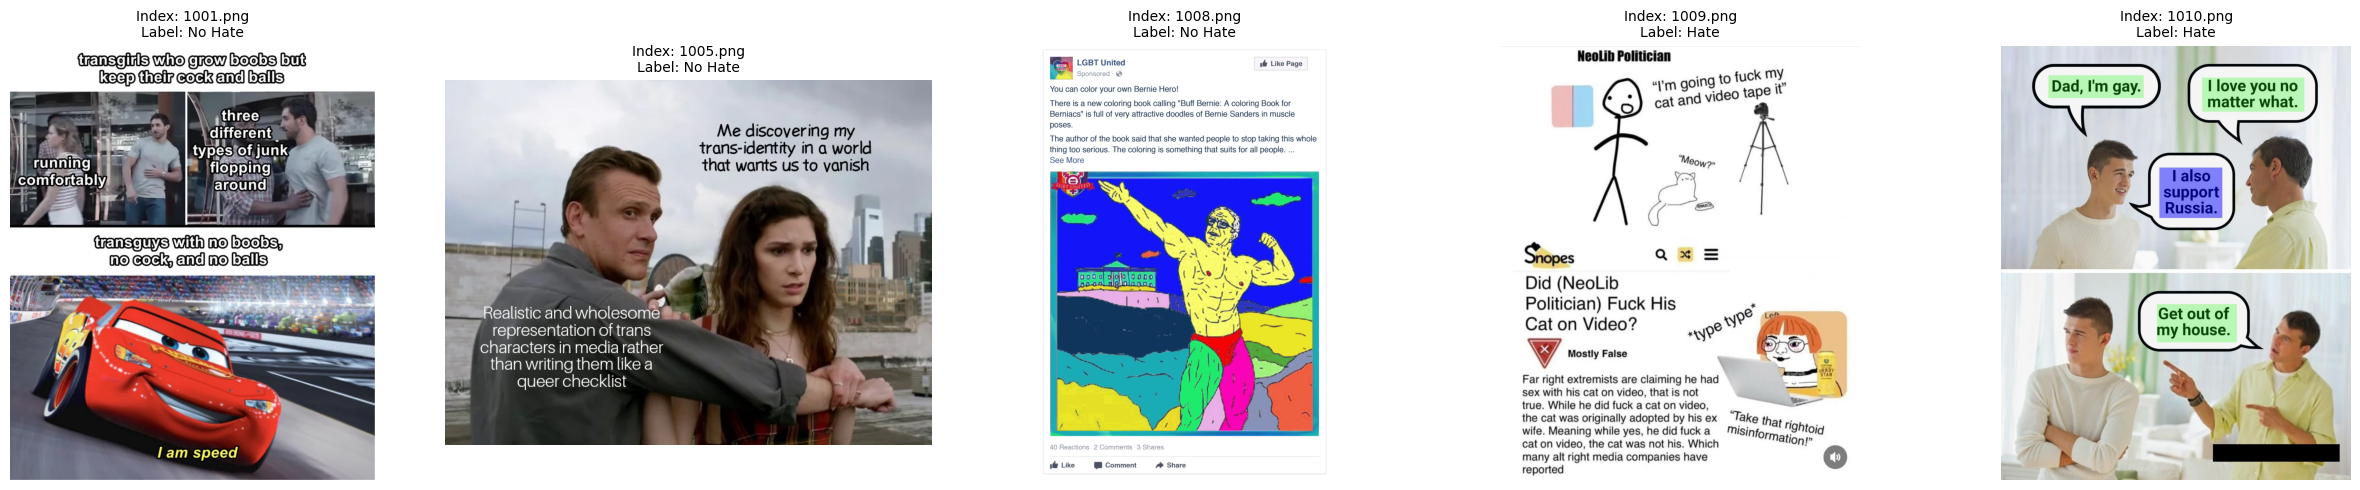


Displaying Validation Samples:


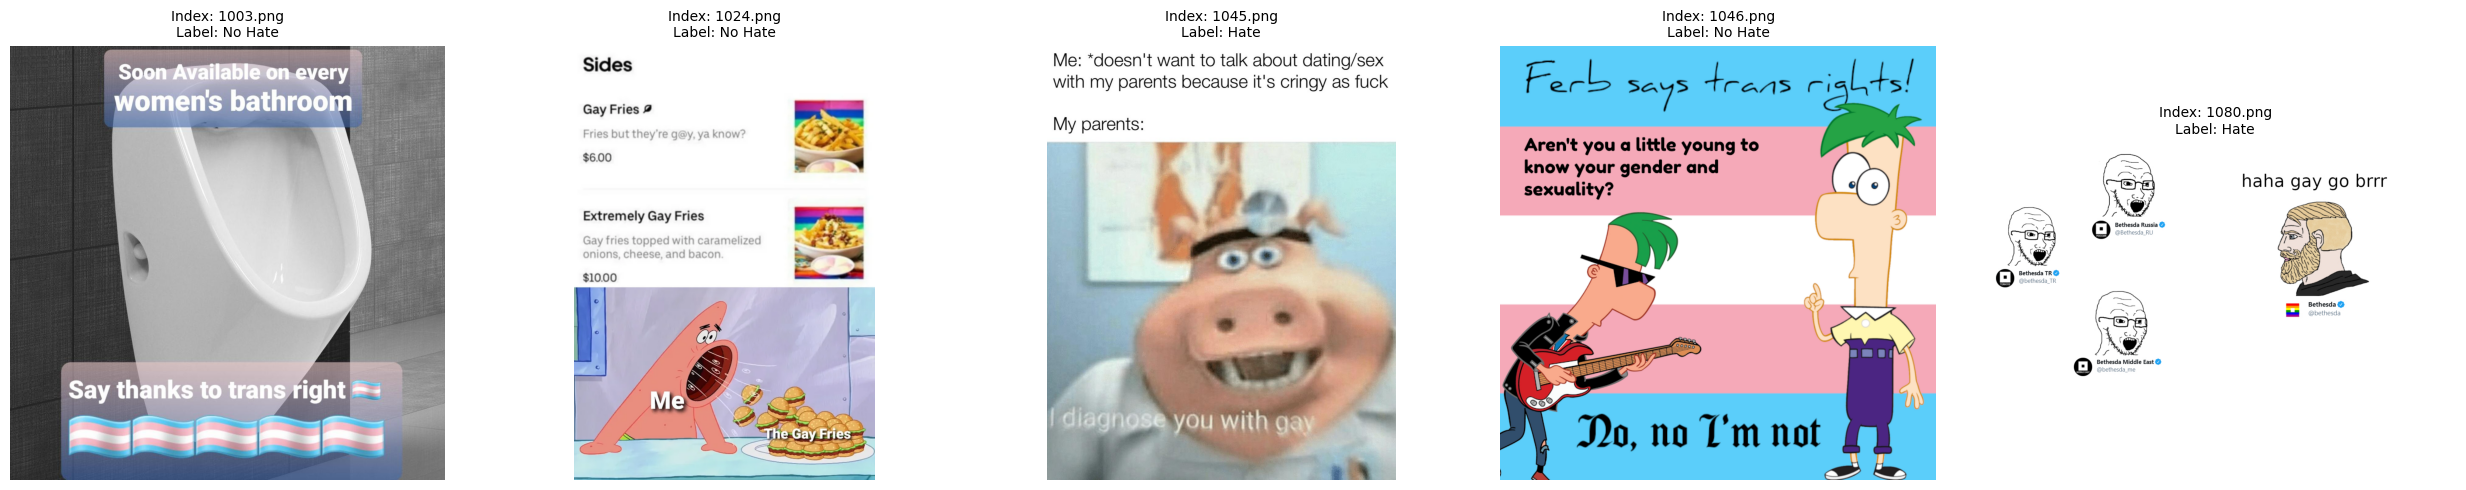


Displaying Test Samples:


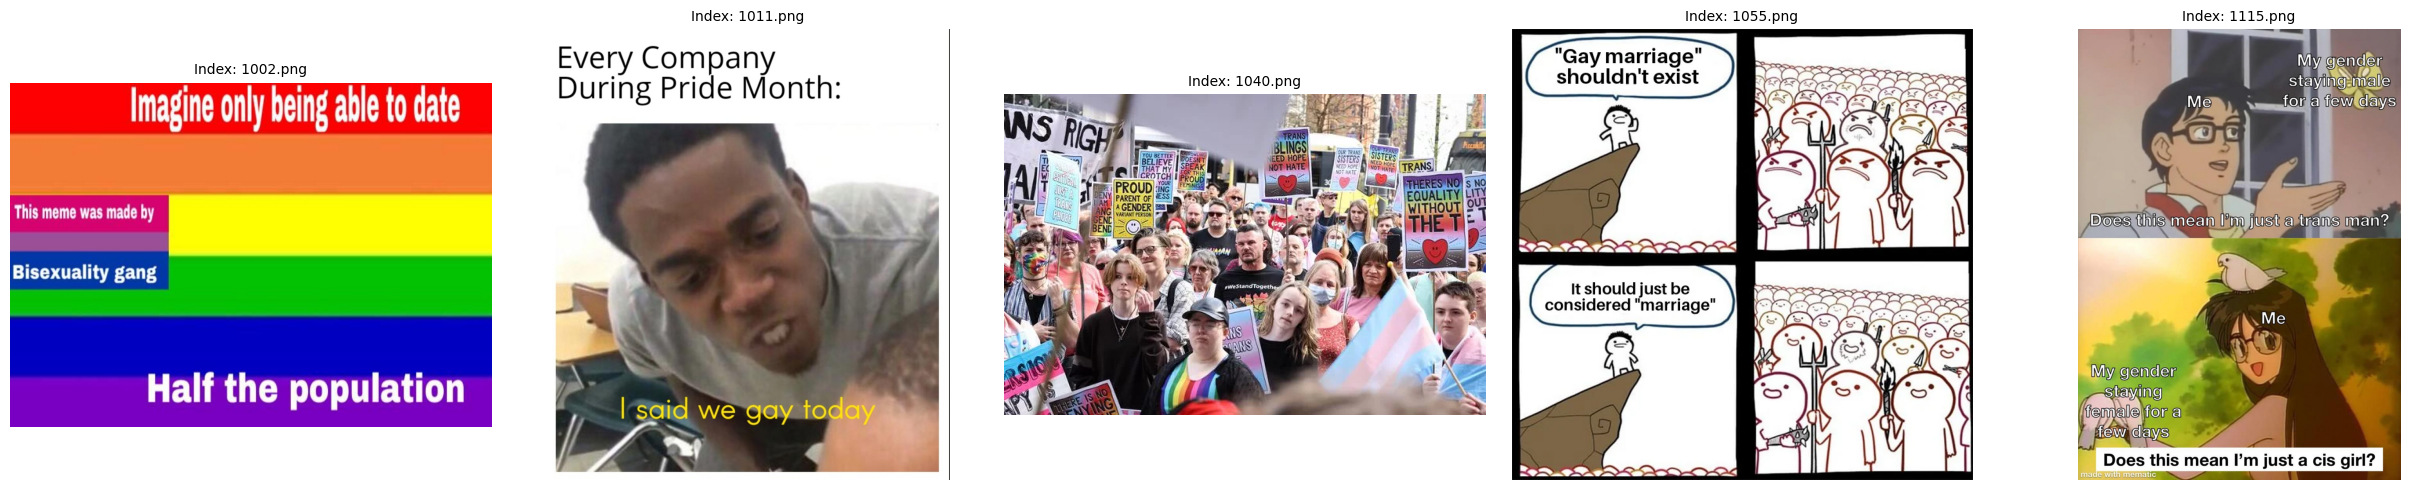

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

{"timestamp":"2025-07-23T17:47:29.817030Z","level":"WARN","fields":{"message":"Status Code: 504. Retrying...","request_id":""},"filename":"/home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs","line_number":236}
{"timestamp":"2025-07-23T17:47:29.817081Z","level":"WARN","fields":{"message":"Retry attempt #0. Sleeping 883.592988ms before the next attempt"},"filename":"/root/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/reqwest-retry-0.7.0/src/middleware.rs","line_number":171}


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json
import zipfile
from transformers import SwinForImageClassification

# Paths to datasets
image_base_path = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset"
train_csv = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_train.csv"
val_csv = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_val.csv"
test_csv = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_test.csv"

# Load datasets
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Construct image paths
def get_train_image_path(row):
    folder = "Hate" if row['label'] == 1 else "No Hate"
    return os.path.join(image_base_path, f"A_train_img/{folder}/{row['index']}")

train_df['image_path'] = train_df.apply(get_train_image_path, axis=1)
val_df['image_path'] = val_df['index'].apply(lambda x: os.path.join(image_base_path, f"A_val_img/{x}"))
test_df['image_path'] = test_df['index'].apply(lambda x: os.path.join(image_base_path, f"A_test_img/{x}"))

# Check for missing images and remove them
def filter_missing_images(df, name="dataset"):
    valid_rows = []
    missing_count = 0
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Checking images in {name}"):
        if os.path.exists(row['image_path']):
            valid_rows.append(row)
        else:
            missing_count += 1
    print(f"{name}: Removed {missing_count} samples with missing images")
    return pd.DataFrame(valid_rows).reset_index(drop=True)

train_df = filter_missing_images(train_df, "train")
val_df = filter_missing_images(val_df, "val")
test_df = filter_missing_images(test_df, "test")

# Image preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset for images only
class ImageDataset(Dataset):
    def __init__(self, df, transform, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test
        self.image_paths = df['image_path'].tolist()
        if not is_test:
            self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        if self.is_test:
            return {
                'image': image,
                'index': self.df['index'].iloc[idx]
            }
        return {
            'image': image,
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

# Create datasets and dataloaders
train_dataset = ImageDataset(train_df, train_transform)
val_dataset = ImageDataset(val_df, val_test_transform)
test_dataset = ImageDataset(test_df, val_test_transform, is_test=True)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Function to display images with labels or indices
def display_samples(df, dataset_name, num_samples=5, is_test=False):
    samples = df.head(min(num_samples, len(df)))
    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
    if num_samples == 1:
        axes = [axes]
    
    for i, (_, row) in enumerate(samples.iterrows()):
        image_path = row['image_path']
        image = Image.open(image_path).convert('RGB')
        axes[i].imshow(image)
        axes[i].axis('off')
        if is_test:
            title = f"Index: {row['index']}"
        else:
            label = "Hate" if row['label'] == 1 else "No Hate"
            title = f"Index: {row['index']}\nLabel: {label}"
        axes[i].set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Display samples from each dataset
print("Displaying Train Samples:")
display_samples(train_df, "train")
print("\nDisplaying Validation Samples:")
display_samples(val_df, "val")
print("\nDisplaying Test Samples:")
display_samples(test_df, "test", is_test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Unimodal Swin Transformer model
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        self.swin_model = SwinForImageClassification.from_pretrained(
            "microsoft/swin-tiny-patch4-window7-224",
            num_labels=1,  # Binary classification
            ignore_mismatched_sizes=True  # Handle potential pretrained head mismatch
        )
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

    def forward(self, image):
        outputs = self.swin_model(pixel_values=image)
        logits = outputs.logits.squeeze(-1)  # [batch_size, 1]
        return logits

# Initialize model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Training loop
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(images).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(images).squeeze()
            preds.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    preds = [1 if p >= 0.5 else 0 for p in preds]
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, zero_division=0)
    precision = precision_score(true_labels, preds, zero_division=0)
    recall = recall_score(true_labels, preds, zero_division=0)
    return accuracy, f1, precision, recall



In [3]:
# Training loop
num_epochs = 10
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1, val_precision, val_recall = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, "
          f"Val Accuracy = {val_acc:.4f}, Val F1 = {val_f1:.4f}, "
          f"Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")



Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Epoch 1: Train Loss = 0.6680, Val Accuracy = 0.6561, Val F1 = 0.7138, Val Precision = 0.6028, Val Recall = 0.8750


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Epoch 2: Train Loss = 0.6063, Val Accuracy = 0.6462, Val F1 = 0.6200, Val Precision = 0.6547, Val Recall = 0.5887


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch 3: Train Loss = 0.5267, Val Accuracy = 0.6779, Val F1 = 0.6772, Val Precision = 0.6654, Val Recall = 0.6895


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Epoch 4: Train Loss = 0.4290, Val Accuracy = 0.6502, Val F1 = 0.6258, Val Precision = 0.6578, Val Recall = 0.5968


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch 5: Train Loss = 0.3198, Val Accuracy = 0.6423, Val F1 = 0.6091, Val Precision = 0.6558, Val Recall = 0.5685


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch 6: Train Loss = 0.2242, Val Accuracy = 0.6700, Val F1 = 0.6782, Val Precision = 0.6494, Val Recall = 0.7097


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Epoch 7: Train Loss = 0.1613, Val Accuracy = 0.6502, Val F1 = 0.6395, Val Precision = 0.6461, Val Recall = 0.6331


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Epoch 8: Train Loss = 0.1222, Val Accuracy = 0.6067, Val F1 = 0.5446, Val Precision = 0.6296, Val Recall = 0.4798


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Epoch 9: Train Loss = 0.1087, Val Accuracy = 0.6700, Val F1 = 0.6528, Val Precision = 0.6738, Val Recall = 0.6331


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]

Epoch 10: Train Loss = 0.0783, Val Accuracy = 0.6542, Val F1 = 0.6421, Val Precision = 0.6515, Val Recall = 0.6331


In [4]:
# Test predictions
model.eval()
test_preds = []
test_indices = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        images = batch['image'].to(device)
        indices = batch['index']
        
        logits = model(images).squeeze()
        preds = torch.sigmoid(logits).cpu().numpy()
        preds = [1 if p >= 0.5 else 0 for p in preds]
        test_preds.extend(preds)
        test_indices.extend(indices)



Predicting: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


In [5]:
# Create JSON Lines submission
submission_data = [{"index": f"{idx}.png", "prediction": pred} for idx, pred in zip(test_indices, test_preds)]
submission_data = sorted(submission_data, key=lambda x: int(x['index'].replace('.png', '')))
with open("submission.json", "w") as f:
    for entry in submission_data:
        f.write(json.dumps(entry) + "\n")
print("Test predictions saved to submission.json")

# Create ref.zip with submission.json
with zipfile.ZipFile("ref.zip", "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write("submission.json")
print("Zipped submission.json into ref.zip")

Test predictions saved to submission.json
Zipped submission.json into ref.zip
